In [3]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement
from src.utils import Discretizer
from src.trainer import run_experiment
from src.plots import plot_gridworld

import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac
from src.models import PARAFAC

from itertools import product

import torch
from tensorly.tenalg import khatri_rao

In [2]:
from src.agents.bcd_grid import bcd

k_list = [10,20,30]
scale = 0.5
num_iter = 50

ENV = GridWorldEnv()

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1



In [3]:
fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_inv = bcd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

    fo_values,errors,convs, Q = bcd_inv.run(num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)

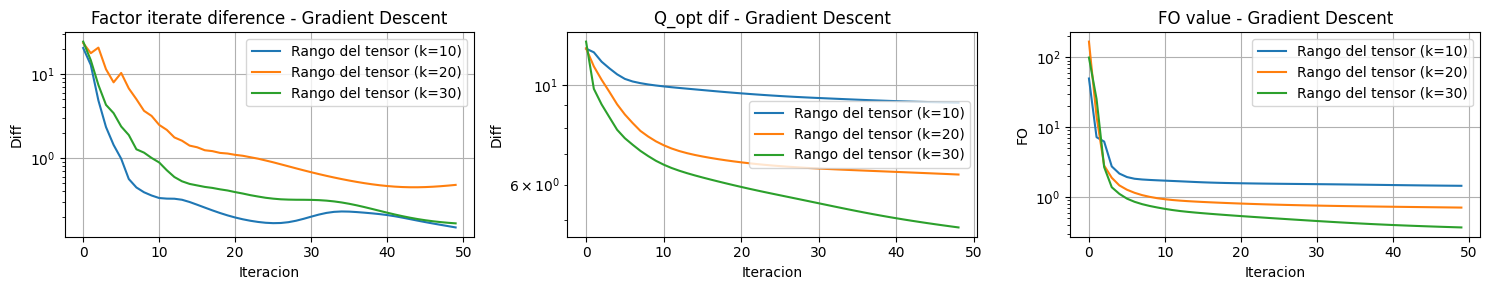

In [4]:

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 filas, 1 columna

for k in range(len(k_list)):
    fo_values = fo_list[k]
    errors = errors_list[k]
    convs = conv_list[k]
    # Primer subplot: Seno
    axes[0].plot(convs,label = f"Rango del tensor (k={k_list[k]})")
    axes[0].set_title("Factor iterate diference - Gradient Descent")
    axes[0].set_xlabel("Iteracion")
    axes[0].set_ylabel("Diff")
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].grid(True)

    # Segundo subplot: Coseno
    axes[1].plot(errors[1:],label = f"Rango del tensor (k={k_list[k]})")
    axes[1].set_title("Q_opt dif - Gradient Descent")
    axes[1].set_xlabel("Iteracion")
    axes[1].set_ylabel("Diff")
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].grid(True)

    # Tercer subplot: Tangente
    axes[2].plot(fo_values ,label = f"Rango del tensor (k={k_list[k]})")
    axes[2].set_title("FO value - Gradient Descent")
    axes[2].set_xlabel("Iteracion")
    axes[2].set_ylabel("FO")
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].grid(True)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [11]:
from src.agents.bcd_grid import bcgd

# GridWorld
k_list = [20, 50, 100]
scale = 4
num_iter = 500
alpha = 10e-8
use_q_qopt = False

ENV = GridWorldEnv()

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

if use_q_qopt == True:
    new_values = parafac(Q_opt, rank=k)[1]
    with torch.no_grad():  # Desactivamos el cálculo de gradientes para la actualización direct
        i = 0
        for i in range(len(new_values)):
            shape = new_values[i].shape
            new_values[i] = new_values[i] + np.random.rand(*shape)*0.0001
            
        for param, new_value in zip(Q.factors, new_values):
            param.copy_(torch.tensor(new_value))  # Copiar los nuevos valores al parámetro existente

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

In [12]:
fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_grad = bcgd(Q,Pi,discretizer,ENV,k,Q_opt.reshape(ENV.H,5,5,ENV.nA),alpha)

    fo_values,errors,convs, Q = bcd_grad.run(num_iter)
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)


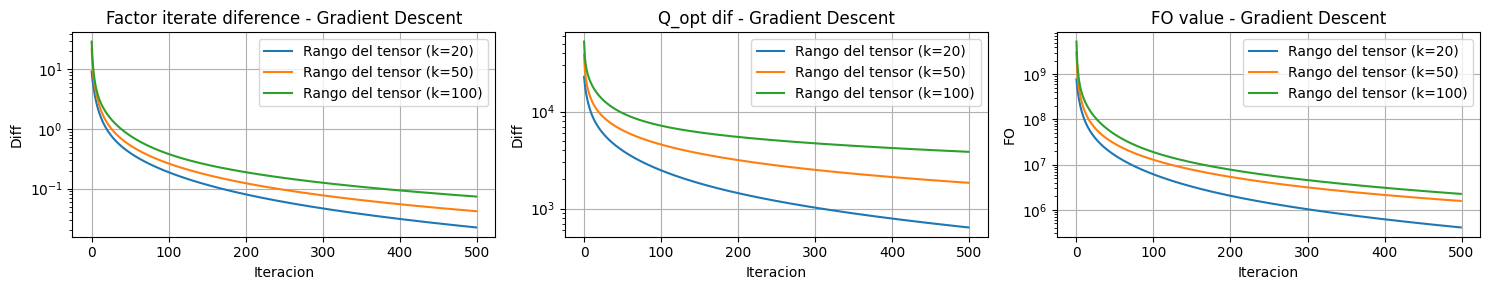

In [13]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 filas, 1 columna

for k in range(len(k_list)):
    fo_values = fo_list[k]
    errors = errors_list[k]
    convs = conv_list[k]
    # Primer subplot: Seno
    axes[0].plot(convs,label = f"Rango del tensor (k={k_list[k]})")
    axes[0].set_title("Factor iterate diference - Gradient Descent")
    axes[0].set_xlabel("Iteracion")
    axes[0].set_ylabel("Diff")
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].grid(True)

    # Segundo subplot: Coseno
    axes[1].plot(errors,label = f"Rango del tensor (k={k_list[k]})")
    axes[1].set_title("Q_opt dif - Gradient Descent")
    axes[1].set_xlabel("Iteracion")
    axes[1].set_ylabel("Diff")
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].grid(True)

    # Tercer subplot: Tangente
    axes[2].plot(fo_values, label = f"Rango del tensor (k={k_list[k]})")
    axes[2].set_title("FO value - Gradient Descent")
    axes[2].set_xlabel("Iteracion")
    axes[2].set_ylabel("FO")
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].grid(True)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

COMPROBACIÓN DE NORMAS

In [4]:
from src.agents.bcd import bcd

k = 10
scale = 100
num_iter = 100

ENV = GridWorldEnv()

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5,5],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1
        
Q = PARAFAC(
        np.concatenate(
            [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
        ),
        k=k,
        scale= scale,
        nA=len(discretizer.bucket_actions),
    ).double()

r = np.sum(np.multiply(ENV.R, ENV.P),axis=0).reshape(-1)
r_t = np.transpose(np.sum(np.multiply(ENV.R, ENV.P),axis=0).reshape(ENV.W,ENV.W,-1),(1,0,2)).reshape(-1)

In [5]:
from src.agents.bcd import calculate_Ds, calculate_Da, calculate_Dh

H = Q.factors[0].detach().numpy()
A = Q.factors[1+len(discretizer.bucket_states):][0].detach().numpy()
S1 = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][0].detach().numpy()
S2 = Q.factors[1:len(Q.factors)-len(discretizer.bucket_actions)][1].detach().numpy()
S = khatri_rao([S1,S2])


In [6]:
Ds = calculate_Ds(S, A, H, ENV, Pi)
Da = calculate_Da(S, A, H, ENV, Pi)
Dh = calculate_Dh(S, A, H, ENV, Pi, k)

print("Norma problema 1")
# Norma del problema 1
norm = []
P1 = []
r = np.sum(np.multiply(ENV.R, ENV.P),axis=0).reshape(-1)
P_sa_s = np.transpose(ENV.P, (1, 2, 0)).reshape(ENV.nS*ENV.nA,ENV.nS)
Q_h = tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))
for h in range(ENV.H):
    if h < ENV.H-1:
        P_pi_h = np.zeros((ENV.nS*ENV.nA, ENV.nS*ENV.nA))
        Pi_h = Pi[h+1,:]
        for nSnA in range(ENV.nS*ENV.nA):
            P_pi_h[nSnA,:] = (Pi_h * P_sa_s[nSnA,:].reshape(-1, 1)).reshape(-1)
        norm.append(np.linalg.norm(r+np.matmul(P_pi_h,Q_h[h+1,:].reshape(-1))-Q_h[h,:].reshape(-1))**2)
        P1.append(r+np.matmul(P_pi_h,Q_h[h+1,:].reshape(-1))-Q_h[h,:].reshape(-1))
    else:
        norm.append(np.linalg.norm(r-Q_h[h,:].reshape(-1))**2)
        P1.append(r-Q_h[h,:].reshape(-1))

print(np.sum(norm))

print("Norma con el S")
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Ds,(S).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Da,(A.T).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Dh,(H).reshape(-1)),ord=2)**2)

from src.agents.bcd_grid import calculate_Ds1,calculate_Ds2, calculate_Da, calculate_Dh

Ds1 = calculate_Ds1(S1,S2, A, H, ENV, Pi)
Ds2 = calculate_Ds2(S1,S2, A, H, ENV, Pi)
Da = calculate_Da(S1,S2, A, H, ENV, Pi)
Dh = calculate_Dh(S1,S2, A, H, ENV, Pi, k)

print("Norma con S1 y S2")
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Ds1,(S1).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r_t, (ENV.H, 1)).reshape(-1) + np.matmul(Ds2,(S2).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Da,(A.T).reshape(-1)),ord=2)**2)
print(np.linalg.norm(np.tile(r, (ENV.H, 1)).reshape(-1) + np.matmul(Dh,(H).reshape(-1)),ord=2)**2)

Norma problema 1
1.6692555600752856e+20
Norma con el S
1.6692555600752853e+20
1.6692555600752853e+20
1.6692555600752853e+20
Norma con S1 y S2
1.6692555600752853e+20
1.6692555600752853e+20
1.6692555600752853e+20
1.6692555600752853e+20


BCD con S

In [ ]:
from src.agents.bcd import bcd

k = 10
scale = 100
num_iter = 10

ENV = GridWorldEnv()

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[25],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1





In [8]:
k_list = [5,10,20,30]
fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_inv = bcd(Q,Pi,discretizer,ENV,num_iter,k,Q_opt)

    fo_values,errors,convs, Q = bcd_inv.run()
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)

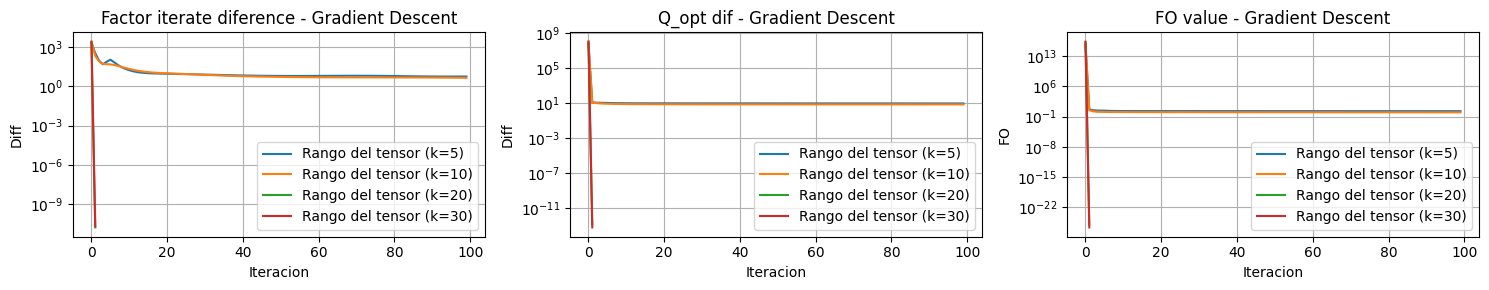

In [9]:
k_list = [5,10,20,30]
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 filas, 1 columna

for k in range(len(k_list)):
    fo_values = fo_list[k]
    errors = errors_list[k]
    convs = conv_list[k]
    # Primer subplot: Seno
    axes[0].plot(convs,label = f"Rango del tensor (k={k_list[k]})")
    axes[0].set_title("Factor iterate diference - Gradient Descent")
    axes[0].set_xlabel("Iteracion")
    axes[0].set_ylabel("Diff")
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].grid(True)

    # Segundo subplot: Coseno
    axes[1].plot(errors,label = f"Rango del tensor (k={k_list[k]})")
    axes[1].set_title("Q_opt dif - Gradient Descent")
    axes[1].set_xlabel("Iteracion")
    axes[1].set_ylabel("Diff")
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].grid(True)

    # Tercer subplot: Tangente
    axes[2].plot(fo_values ,label = f"Rango del tensor (k={k_list[k]})")
    axes[2].set_title("FO value - Gradient Descent")
    axes[2].set_xlabel("Iteracion")
    axes[2].set_ylabel("FO")
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].grid(True)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [18]:
from src.agents.bcd import bcgd

# GridWorld
k_list = [5,10,20,40]
scale = 4
num_iter = 20000
alpha = 10e-6
use_q_qopt = False

ENV = GridWorldEnv()

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[25],
    min_points_actions=[0],
    max_points_actions=[3],
    bucket_actions=[4],
)

if use_q_qopt == True:
    new_values = parafac(Q_opt, rank=k)[1]
    with torch.no_grad():  # Desactivamos el cálculo de gradientes para la actualización direct
        i = 0
        for i in range(len(new_values)):
            shape = new_values[i].shape
            new_values[i] = new_values[i] + np.random.rand(*shape)*0.0001
            
        for param, new_value in zip(Q.factors, new_values):
            param.copy_(torch.tensor(new_value))  # Copiar los nuevos valores al parámetro existente

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1


In [19]:
fo_list = []
errors_list = []
conv_list = []

for k in k_list:
    Q = PARAFAC(
            np.concatenate(
                [[ENV.H], discretizer.bucket_states, discretizer.bucket_actions]
            ),
            k=k,
            scale= scale,
            nA=len(discretizer.bucket_actions),
        ).double()
    
    bcd_grad = bcgd(Q,Pi,discretizer,ENV,num_iter,k,Q_opt,alpha)

    fo_values,errors,convs, Q = bcd_grad.run()
    fo_list.append(fo_values)
    errors_list.append(errors)
    conv_list.append(convs)


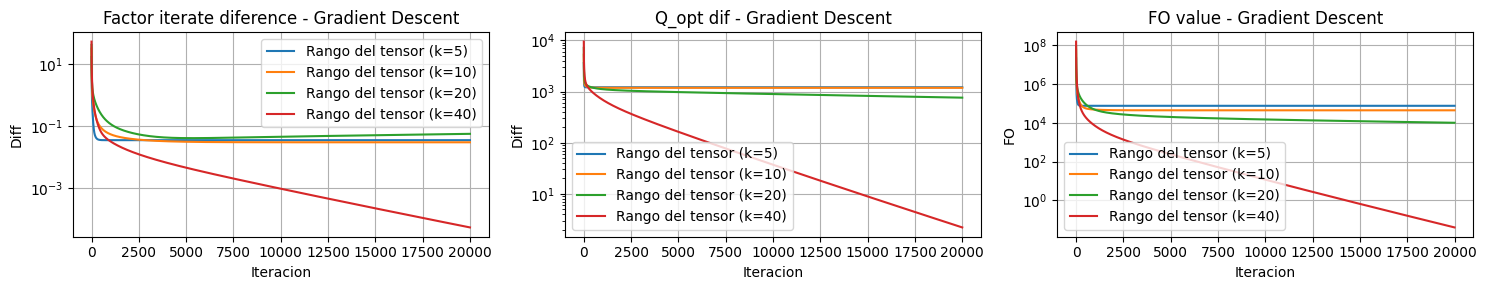

In [20]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 3 filas, 1 columna

for k in range(len(k_list)):
    fo_values = fo_list[k]
    errors = errors_list[k]
    convs = conv_list[k]
    # Primer subplot: Seno
    axes[0].plot(convs,label = f"Rango del tensor (k={k_list[k]})")
    axes[0].set_title("Factor iterate diference - Gradient Descent")
    axes[0].set_xlabel("Iteracion")
    axes[0].set_ylabel("Diff")
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].grid(True)

    # Segundo subplot: Coseno
    axes[1].plot(errors,label = f"Rango del tensor (k={k_list[k]})")
    axes[1].set_title("Q_opt dif - Gradient Descent")
    axes[1].set_xlabel("Iteracion")
    axes[1].set_ylabel("Diff")
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].grid(True)

    # Tercer subplot: Tangente
    axes[2].plot(fo_values, label = f"Rango del tensor (k={k_list[k]})")
    axes[2].set_title("FO value - Gradient Descent")
    axes[2].set_xlabel("Iteracion")
    axes[2].set_ylabel("FO")
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].grid(True)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()